<a href="https://colab.research.google.com/github/whyzhuce/XConparraison/blob/master/Forward_start_option_perf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Option forward start sur performance
---
> **Antonin Chaix**

Le but de ce TP est d'étudier l'option de payoff en $T_2$ :

$$
\left(\frac{S_{T_2}}{S_{T_1}} - k\right)^+
$$

avec $0 < T_1 < T_2$ et $S$ un actif sans dividendes. Financièrement, si $k=1$, cette option paye la performance positive de l'actif $S$ sur la période $[T_1, T_2]$. Si $k=1.1$, elle paye le surplus de performance de l'actif au-delà de 10%.

S'il elle paraît simple au premier abord, cette option est en réalité très dangereuse car elle intègre un fort risque de *vol forward* : en vendant une telle option, on s'engage sur le niveau de la volatilité implicite future.

En effet... Prenons à nouveau la situation où $k=1$. On s'engage à livrer en $T_1$ une option à la monnaie de maturité $T_2$ sur l'actif normalisé $\frac{S_{T_2}}{S_{T_1}}$ (c'est à dire sur la performance de l'actif entre $T_1$ et $T_2$). En l'absence de dividende, et avec un taux d'intérêt nul, l'approximation classique pour la valeur des cette option en $T_1$ est :

$$
0.4\times\sigma\sqrt{T_2-T_1}
$$

où $\sigma$ représente la valeur de la volatilité implicite en $T_1$ d'une option ATM de maturité $T_2$ sur l'actif $S$.

Ainsi le payoff de notre option dépend *exclusivement* du niveau *futur* de la volatilité implicite. A noter que puisque le call forward start porte sur l'actif normalisé $\frac{S_{T_2}}{S_{T_1}}$, cette option n'a ni delta, ni gamma ! Un modèle à volatilité stochastique est donc hautement souhaitable pour évaluer et risk-manager cette option...

**Idée du TP** : évaluer cette option avec un modèle à vol stochastique (SABR) et comparer avec les valeurs obtenues lorsque l'on utilise (naïvement) Black-Scholes...

Pour plus de précisions sur le modèle SABR et la façon d'implémenter le Monte Carlo associé, se reporter à [ce TP](https://colab.research.google.com/drive/1NhQqGLtLBl1ACUDOKEJkbUzi7cMbbiax?usp=sharing).


## Simulation des trajectoires dans le modèle SABR

In [ ]:
import numpy as np
import math

# underlying params
S0 = 100.
r = 0

# SABR params
sigma0 = 0.20 # vol initiale
alpha = 0.6 # volvol
rho = -0.55 # correl fwd/vol
beta =  1. # exposant CEV

# MC params
Nsimul = 5*10**5
Nsteps = 100

t2 = 1. # MC horizon = option maturity
t = np.linspace(0, t2, Nsteps+1, endpoint=True); # discrétisation en temps
i_t1 = int(Nsteps/2) # index de t1 dans la discrétisation en temps : à mi-chemin
t1 = t[i_t1]

# precalcs
dt = t2 / Nsteps
sqrt_dt = math.sqrt(dt)

# generate gaussian random variables (with correl)
norm1 = np.random.normal(0, 1, (Nsteps, Nsimul))
norm2 = rho * norm1 + math.sqrt(1 - rho ** 2) * np.random.normal(0, 1, (Nsteps, Nsimul))

# forward on time steps x simulations
fwd = np.empty(shape=(Nsteps+1, Nsimul))
fwd[0,:] = S0 * math.exp(r*t2)

# vol on time steps x simulations
sigma = np.empty(shape=(Nsteps+1, Nsimul))
sigma[0,:] = sigma0

# MC loop SABR
for i in range(Nsteps) :
	fwd[i+1,:] = fwd[i,:] + sigma[i,:] * np.power(fwd[i,:], beta) * sqrt_dt * norm1[i,:]
	sigma[i+1,:] = sigma[i,:] * np.exp(-0.5 * alpha**2 * dt + alpha * sqrt_dt * norm2[i,:])

# calcul du spot SABR à partir du fwd
S_sabr = fwd * np.exp(-r*(t2-t[:, np.newaxis]))

## Fonctions utiles

Pour la suite, nous avons besoin :

* de la formule de Black & Scholes
* de la formule (approchée) donnant la vol implicite lognormale dans le modèle SABR
* d'une petite fonction pour calculer et afficher prix Monte Carlo + intervalle de confiance à partir des trajectoires de l'actif


In [ ]:
from scipy.stats import norm

# BS formula for a call / numpy compatible
def bs_call(T, K, F0, sigma) :
    sigma_sqrt_T = sigma * np.sqrt(T)
    d1 = (np.log(F0/K) + 0.5 * sigma**2 * T) / sigma_sqrt_T
    d2 = d1 - sigma_sqrt_T
    return F0 * norm.cdf(d1) - K * norm.cdf(d2)


# SABR lognormal vol formula from [https://github.com/ynouri/pysabr] made numpy compatible
def sabr_vol (T, K, F0, sigma0, alpha, rho, beta) :
    """
    Hagan's 2002 SABR lognormal vol expansion.
    The strike K can be a scalar or an array, the function will return an array
    of lognormal vols.
    """
    eps = 1e-07
    logfk = np.log(F0 / K)
    fkbeta = (F0*K)**(1 - beta)
    a = (1 - beta)**2 * sigma0**2 / (24 * fkbeta)
    b = 0.25 * rho * beta * alpha * sigma0 / fkbeta**0.5
    c = (2 - 3*rho**2) * alpha**2 / 24
    d = fkbeta**0.5
    v = (1 - beta)**2 * logfk**2 / 24
    w = (1 - beta)**4 * logfk**4 / 1920
    z = alpha * fkbeta**0.5 * logfk / sigma0
    tmp = sigma0 * (1 + (a + b + c) * T)
    num = np.where(abs(z) > eps, z * tmp, tmp)
    den = np.where(abs(z) > eps, (d * (1 + v + w) * _x(rho, z)), d * (1 + v + w))
    return num / den

def _x(rho, z):
    """Return function x used in Hagan's 2002 SABR lognormal vol expansion."""
    a = (1 - 2*rho*z + z**2)**.5 + z - rho
    b = 1 - rho
    return np.log(a / b)

# compute and display price & confidence interval
def compute_and_print_price(payoff, option_name, closed_form_price = -1) :
    price = payoff.mean()
    stdev = np.std(payoff)
    IClow = price - 1.96 * stdev / math.sqrt(Nsimul)
    ICup = price + 1.96 * stdev / math.sqrt(Nsimul)
    if (closed_form_price == -1) : print("{} = {:.4f}".format(option_name, price) )
    else :  print("{} = {:.4f} (closed-form price = {:.4f})".format(option_name, price, closed_form_price) )
    print("IC 95% = [{:.4f} ; {:.4f}]".format(IClow,ICup) )
    print("-----------------------------------------------------")


## Pricing de l'option dans le modèle SABR et comparaison avec BS

Dans le cadre du Monte Carlo SABR (où on simule $n$ trajectoires indicées ci-dessous avec $i$), il y a plusieurs façons d'évaluer l'option.

La plus naturelle est d'utiliser l'estimateur :

$$
\frac{1}{n}\sum_{i=1}^n e^{-rT_2} \left(\frac{S_{T_2}^i}{S_{T_1}^i}-k\right)^+
$$

Mais on peut également écrire que l'on reçoit en $T_1$ un call de strike $k$ sur l'actif normalisé (c'est à dire un call de strike $k-1$ sur la performance de l'actif entre $T_1$ et $T_2$), ce qui nous donne l'estimateur :

$$
e^{-rT_1}\frac{1}{n}\sum_{i=1}^n e^{-r(T_2-T_1)}\,\text{BScall}\left(T=T_2-T_1, K=k, F_0=e^{r(T_2-T_1)},\sigma=\sigma_{\text{sabr}}^i\right)
$$

où $\sigma_{\text{sabr}}^i$ représente la volatilité (forward) du call dans le modèle SABR en $T_1$ pour la maturité $T_2$, donc pour le niveau de spot $S_{T_1}^i$, le strike $k\times S_{T_1}^i$ et la volatilité SABR $\sigma_{T_1}^i$ :

$$
\sigma_{\text{sabr}}^i = \sigma_{\text{sabr}}\left(T=T_2-T_1, K=k S_{T_1}^i, F_0=S_{T_1}^i e^{r(T_2-T_1)}, \sigma_0=\sigma_{T_1}^i, α	, ρ, β\right)
$$

Dans le cas où $r=0$ et $k=1$, le call sous-jacent est ATM forward ce qui nous permet d'utiliser l'approximation :

$$
\text{BScall}\left(T_2-T_1, k, e^{r(T_2-T_1)},\sigma_{\text{sabr}}^i\right) = \text{BScall}\left(T_2-T_1, 1, 1,\sigma_{\text{sabr}}^i\right)\approx \frac{1}{\sqrt{2π}}\sigma_{\text{sabr}}^i\sqrt{T_2-T_1}
$$

Pour évaluer l'option dans le modèle de Black & Scholes, rien de plus simple : son payoff en $T_1$ est déterministe (d'où le côté très inapproprié de l'utilisation de ce modèle !). En $T_1$, on reçoit le call sur performance, dont la valeur ne dépend pas du niveau de l'actif en $T_1$, mais uniquement de la vol forward $T_1\rightarrow T_2$, c'est à dire tout simplement la volatilité $\sigma$ du modèle de Black & Scholes. Son prix est donc:

$$
e^{-rT_1}\,e^{-r(T_2-T_1)}\,\text{BScall}\left(T=T_2-T_1, K=k, F_0=e^{r(T_2-T_1)},\sigma\right) = e^{-rT_2}\,\text{BScall}\left(T_2-T_1, k, e^{r(T_2-T_1)},\sigma\right)
$$

Connaissant en $t=0$ le smile de volatilité pour la maturité $T_2$, c'est à dire les paramètres SABR, il est pertinent de choisir comme vol $\sigma$ du modèle BS, la vol forward dans le modèle SABR, c'est à dire :

$$
\sigma =  \sigma_{\text{sabr}}\left(T=T_2-T_1, K=k S_0, F_0=S_0e^{r(T_2-T_1)}, \sigma_0, α	, ρ, β\right)
$$


### Cas ATM $(k=1)$

Voyons voir ci-dessous ce que donnent ces différentes méthodes pour évaluer l'option dans le cas où $k=1$.

In [ ]:
# ===========================================================
# Option pays : gearing * 100 * (S(t2)/S(t1) - k)^+
# ===========================================================
k = 1.0
gearing = 1.0

# some display
print("SABR | sigma0 = {} | alpha = {} | rho = {} | beta = {} |".format(sigma0, alpha, rho, beta))
print("INPUTS | {:,} simulations | {} time steps | r = {} | T1 = {} | T2 = {} | k = {} | gearing = {} |\n".format(Nsimul, Nsteps, r, t1, t2, k, gearing).replace(',', ' '))

# Compute payoffs...

# Méthode 1 : MC to T2
payoff_fwd_start_sabr_1 = gearing * 100. * math.exp(-r*t2) * np.maximum(S_sabr[-1,:]/S_sabr[i_t1,:] - k, 0)  #

# Méthode 2 : MC to T1 + Black & Scholes
fwd_vol_sabr = sabr_vol (t2-t1, S_sabr[i_t1,:] * k, fwd[i_t1,:], sigma[i_t1,:], alpha, rho, beta)
payoff_fwd_start_sabr_2 = gearing * 100. * math.exp(-r*t1) * math.exp(-r*(t2-t1)) * bs_call(t2-t1, k, math.exp(r*(t2-t1)), fwd_vol_sabr)

# Méthode 3 : MC to T1 + Approx Black & Scholes (option ATM forward)
payoff_fwd_start_sabr_3 = gearing * 100. * math.exp(-r*t1) * (1./math.sqrt(2.*math.pi)) * fwd_vol_sabr * math.sqrt(t2-t1) # approx ATM forward, ne marche que si k=1 et r=0

# compute & display MC prices
compute_and_print_price(payoff_fwd_start_sabr_1, "Prix SABR - méthode 1 (MC to T2)")
compute_and_print_price(payoff_fwd_start_sabr_2, "Prix SABR - methode 2 (MC to T1)")
compute_and_print_price(payoff_fwd_start_sabr_3, "Prix SABR - methode 3 (MC to T1, approx)") # approx ATM forward, ok si k=1 & r=0

# Pricing Black & Scholes
vol_bs = sabr_vol (t2-t1, S0 * k, S0*math.exp(r*(t2-t1)), sigma0, alpha, rho, beta) # SABR fwd vol
bs_price = gearing * 100. * math.exp(-r*t1) * math.exp(-r*(t2-t1)) * bs_call(t2-t1, k, math.exp(r*(t2-t1)), vol_bs)
print("Prix BS = {:.4f}".format(bs_price))
print("\nPrix BS et prix SABR coïncident parfaitement !")


SABR | sigma0 = 0.2 | alpha = 0.6 | rho = -0.55 | beta = 1.0 |
INPUTS | 500 000 simulations | 100 time steps | r = 0 | T1 = 0.5 | T2 = 1.0 | k = 1.0 | gearing = 1.0 |

Prix SABR - méthode 1 (MC to T2) = 5.6257
IC 95% = [5.5995 ; 5.6520]
-----------------------------------------------------
Prix SABR - methode 2 (MC to T1) = 5.6236
IC 95% = [5.6168 ; 5.6304]
-----------------------------------------------------
Prix SABR - methode 3 (MC to T1, approx) = 5.6315
IC 95% = [5.6247 ; 5.6384]
-----------------------------------------------------
Prix BS = 5.6369

Prix BS et prix SABR coïncident parfaitement !


Cette égalité entre le prix SABR de l'option et le prix Black & Scholes était somme toute prévisible. En effet, l'option étant à la monnaie forward, le payoff en $T_1$ de l'option est une fonction linéaire de la vol forward $T_1\rightarrow T_2$ (rappelons-nous que le call reçu en $T_1$ vaut approximativement $0.4 σ \sqrt{T_2-T_1}$ où $\sigma$ est la vol forward $T_1\rightarrow T_2$ dans le modèle utilisé). Confirmons cela avec le graphique suivant...

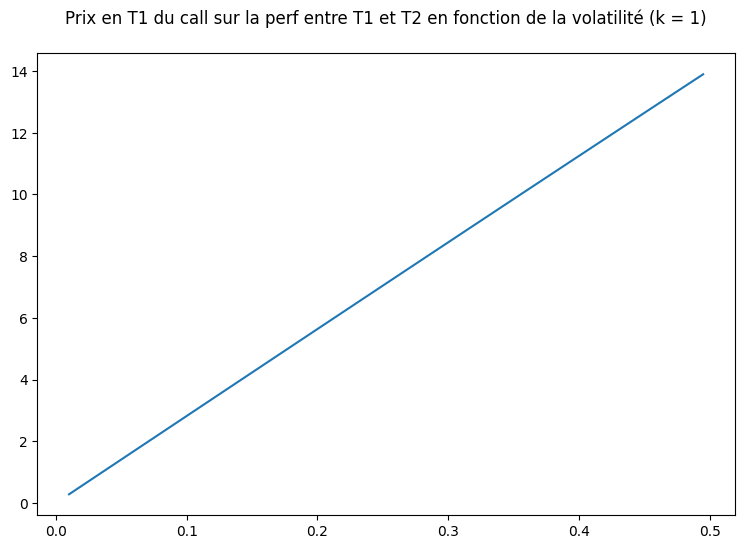

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,6)
k = 1
vols = np.arange(0.01, 0.5, 0.005)
plt.plot(vols, 100.* bs_call(t2-t1, k, 1., vols))
plt.title("Prix en T1 du call sur la perf entre T1 et T2 en fonction de la volatilité (k = 1)\n")
plt.show()

En réalité dans ce cas, seule l'espérance, dans le modèle utilisé, de la vol implicite du call sur perf $T_1\rightarrow T_2$, intervient dans le prix de l'option forward start.

Donc un modèle déterministe sur la volatilité comme Black & Scholes donne le même résultat que le modèle SABR à vol stochastique dès lors que sa volatilité est calibrée sur le smile SABR (ce que nous avons fait) !


### Cas OTM ($k>1)$

Bien sûr les choses ne sont pas toujours aussi simples. Prenons l'exemple d'une option avec $k=1.2$ (l'option paye le surplus de performance entre $T_1$ et $T_2$ de l'actif au delà de 20%), avec un levier de 7 pour garder les mêmes ordres de grandeur sur le prix de l'option.

In [ ]:
# ===========================================================
# Option pays : gearing * 100 * (S(t2)/S(t1) - k)^+
# ===========================================================
k = 1.2
gearing = 7

# some display
print("SABR | sigma0 = {} | alpha = {} | rho = {} | beta = {} |".format(sigma0, alpha, rho, beta))
print("INPUTS | {:,} simulations | {} time steps | r = {} | T1 = {} | T2 = {} | k = {} | gearing = {} |\n".format(Nsimul, Nsteps, r, t1, t2, k, gearing).replace(',', ' '))

# Compute payoffs...

# Méthode 1 : MC to T2
payoff_fwd_start_sabr_1 = gearing * 100. * math.exp(-r*t2) * np.maximum(S_sabr[-1,:]/S_sabr[i_t1,:] - k, 0)  #

# Méthode 2 : MC to T1 + Black & Scholes
fwd_vol_sabr = sabr_vol (t2-t1, S_sabr[i_t1,:] * k, fwd[i_t1,:], sigma[i_t1,:], alpha, rho, beta)
payoff_fwd_start_sabr_2 = gearing * 100. * math.exp(-r*t1) * math.exp(-r*(t2-t1)) * bs_call(t2-t1, k, math.exp(r*(t2-t1)), fwd_vol_sabr)

# compute & display MC prices
compute_and_print_price(payoff_fwd_start_sabr_1, "Prix SABR - méthode 1 (MC to T2)")
compute_and_print_price(payoff_fwd_start_sabr_2, "Prix SABR - methode 2 (MC to T1)")

# Pricing Black & Scholes
vol_bs = sabr_vol (t2-t1, S0 * k, S0*math.exp(r*(t2-t1)), sigma0, alpha, rho, beta) # SABR fwd vol
bs_price = gearing * 100. * math.exp(-r*t1) * math.exp(-r*(t2-t1)) * bs_call(t2-t1, k, math.exp(r*(t2-t1)), vol_bs)
print("Prix BS = {:.4f}".format(bs_price))
print("\nPrix BS et prix SABR ne coïncident plus du tout !")


SABR | sigma0 = 0.2 | alpha = 0.6 | rho = -0.55 | beta = 1.0 |
INPUTS | 500 000 simulations | 100 time steps | r = 0 | T1 = 0.5 | T2 = 1.0 | k = 1.2 | gearing = 7 |

Prix SABR - méthode 1 (MC to T2) = 5.7214
IC 95% = [5.6320 ; 5.8107]
-----------------------------------------------------
Prix SABR - methode 2 (MC to T1) = 5.6773
IC 95% = [5.6517 ; 5.7030]
-----------------------------------------------------
Prix BS = 3.1681

Prix BS et prix SABR ne coïncident plus du tout !


Cette fois-ci la valeur du call payé en $T_1$ n'est plus du tout une fonction linéaire de la volatilité $T_1\rightarrow T_2$, c'est même une fonction très convexe :

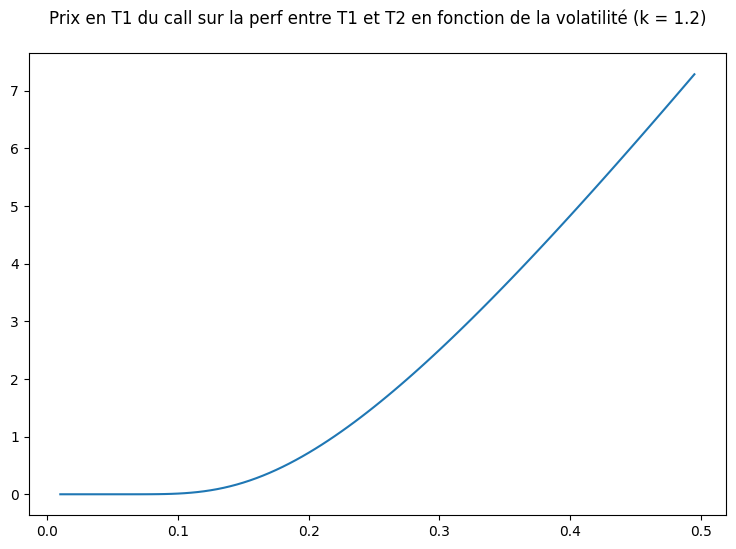

In [ ]:
k = 1.2
plt.plot(vols, 100.* bs_call(t2-t1, k, 1., vols))
plt.title("Prix en T1 du call sur la perf entre T1 et T2 en fonction de la volatilité (k = 1.2)\n")
plt.show()

D'où la différence de prix significative (quasi un facteur 2 entre le prix SABR et le prix BS !).